# Application Study: Time-delay estimation based on events from different observations

**Data:**
1. Breath Rate Data 
1. Step Rate Data

**Experiments:**
1. For each pair of measurement, merge both signal arrays

In [1]:
import os
# Set the path such that the package can be found locally
os.chdir("/home/jovyan/work/Synchronization/git_nearest_advocate/experiments")
import time

import numba
import numpy as np
np.random.seed(0)
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

from sklearn.neighbors import KernelDensity
from sklearn.linear_model import TheilSenRegressor, HuberRegressor

# own utils
from nearest_advocate import nearest_advocate
from data_loader import load_breath_rate, load_step_rate
from utils import moving_aggregation_nb, moving_aggregation
# from nearest_advocate_windowed.nearest_advocate_windowed import nearest_advocate_windowed
from nearest_advocate_windowed.plotting import plot_windowed_result

# Load methods
%matplotlib inline

In [2]:
# directories to load
PATH_BREATH_RATE_DATA = "../data/BreathRateData"
PATH_STEP_RATE_DATA = "../data/StepRateData"

# parameters for Nearest-Advocate
DIST_MAX = None          # use the default values for dist_max of nearest_advocate
TD_MAX = 60               # search space of 10 minutes
TD_MIN = -60
SAMPLES_PER_S = 50        # precision of the search space (for steps of mean freq 0.5s)

# Parameters for the windowed version
WINDOW_LENGTH = 60
SLIDING_LENGTH = 5
# BANDWIDTH = 60
# SPS_ADAPTATION_FACTOR = 1.0

# Parameters for the spectroscopy representation
SAMPLE_RATE_DT = 20
SPECTROSCOPY_XVAL_DT = 0.1  # Time steps

## Data

### Load the datasets

In [3]:
breath_rate_dataset = load_breath_rate(path_to_dir=PATH_BREATH_RATE_DATA, verbose=1)

Loading files P05_Reference_FlowReversals_OVERALL.csv and P05_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P06_Reference_FlowReversals_OVERALL.csv and P06_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P07_Reference_FlowReversals_OVERALL.csv and P07_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P08_Reference_FlowReversals_OVERALL.csv and P08_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P09_Reference_FlowReversals_OVERALL.csv and P09_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P10_Reference_FlowReversals_OVERALL.csv and P10_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P11_Reference_FlowReversals_OVERALL.csv and P11_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P12_Reference_FlowReversals_OVERALL.csv and P12_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P13_Reference_FlowReversals_OVERALL.csv and P13_SportsSRS_FlowReversals_OVERALL.csv.
Loading files P14_Reference_FlowReversals_OVERALL.csv and P14_SportsSRS_FlowReversals_OVERALL.csv.
Loading fi

In [4]:
breath_rate_dataset_d = {k: breath_rate_dataset[i] for i, k in enumerate(
    ['P05', 'P06', 'P07', 'P08', 'P09', 'P10', 'P11', 'P12', 'P13', 'P14', 'P15', 'P16', 'P19', 'P20', 'P21', 'P22', 'P23']
    )}
assert len(breath_rate_dataset_d) == len(breath_rate_dataset)

In [5]:
step_rate_dataset = load_step_rate(path_to_dir=PATH_STEP_RATE_DATA, verbose=1)

Loading files P04_Reference_Strides_OVERALL.csv and P04_SportsSRS_Strides_OVERALL.csv.
Loading files P06_Reference_Strides_OVERALL.csv and P06_SportsSRS_Strides_OVERALL.csv.
Loading files P07_Reference_Strides_OVERALL.csv and P07_SportsSRS_Strides_OVERALL.csv.
Loading files P08_Reference_Strides_OVERALL.csv and P08_SportsSRS_Strides_OVERALL.csv.
Loading files P09_Reference_Strides_OVERALL.csv and P09_SportsSRS_Strides_OVERALL.csv.
Loading files P10_Reference_Strides_OVERALL.csv and P10_SportsSRS_Strides_OVERALL.csv.
Loading files P11_Reference_Strides_OVERALL.csv and P11_SportsSRS_Strides_OVERALL.csv.
Loading files P12_Reference_Strides_OVERALL.csv and P12_SportsSRS_Strides_OVERALL.csv.
Loading files P13_Reference_Strides_OVERALL.csv and P13_SportsSRS_Strides_OVERALL.csv.
Loading files P16_Reference_Strides_OVERALL.csv and P16_SportsSRS_Strides_OVERALL.csv.
Loading files P18_Reference_Strides_OVERALL.csv and P18_SportsSRS_Strides_OVERALL.csv.
Loading files P19_Reference_Strides_OVERALL

In [6]:
step_rate_dataset_d = {k: step_rate_dataset[i] for i, k in enumerate(
    ['P04', 'P06', 'P07', 'P08', 'P09', 'P10', 'P11', 'P12', 'P13', 'P16', 'P18', 'P19', 'P21', 'P23']
    )}
assert len(step_rate_dataset_d) == len(step_rate_dataset)

### Select specific data files

The given files are unfortunately too short (going from)

In [7]:
# arr_breath = np.array(
#             pd.read_csv("../data/full_breath_vs_steps/P07_SportsSRS_FlowReversals_RUNS_MERGED.csv",
#                         sep=";", usecols=["Time"],
#                         converters={"Time": lambda x: float(x.replace(",", "."))})["Time"]
#         )
# arr_step = np.array(
#             pd.read_csv("../data/full_breath_vs_steps/P07_SportsSRS_Strides_RUNS_MERGED.csv",
#                         sep=";", usecols=["x"],
#                         converters={"x": lambda x: float(x.replace(",", "."))})["x"]
#         )
# print(f"Array Ref, min: {np.min(np.diff(arr_breath)):.4f}, median: {np.median(np.diff(arr_breath)):.4f}, max: {np.max(np.diff(arr_breath)):.4f}")
# print(f"Array Sig, min: {np.min(np.diff(arr_step)):.4f}, median: {np.median(np.diff(arr_step)):.4f}, max: {np.max(np.diff(arr_step)):.4f}")

## Data Exploration

In [8]:
pid = 'P07'
ref = False

In [9]:
typ = 0 if ref else 1
arr_breath = breath_rate_dataset_d.get(pid, [None, None])[typ]  # [:1000]
arr_step = step_rate_dataset_d.get(pid, [None, None])[typ]  # [:1000]
# arr_step = breath_rate_dataset_d.get(pid, [None, None])[1-typ]

print(f"Array Ref, min: {np.min(np.diff(arr_breath)):.4f}, median: {np.median(np.diff(arr_breath)):.4f}, max: {np.max(np.diff(arr_breath)):.4f}")
print(f"Array Sig, min: {np.min(np.diff(arr_step)):.4f}, median: {np.median(np.diff(arr_step)):.4f}, max: {np.max(np.diff(arr_step)):.4f}")
arr_breath, arr_step

Array Ref, min: 0.0427, median: 0.9859, max: 4.1787
Array Sig, min: 0.1848, median: 0.3576, max: 1.1464


(array([1757.34974154, 1758.74662057, 1760.77691027, ..., 4142.71179527,
        4145.25437322, 4148.37972872]),
 array([1773.34251959, 1773.79649766, 1774.11736181, ..., 4169.93347589,
        4170.56328354, 4171.00832112]))

In [10]:
# cut array to view only the four running phases
# time_slice = (1896, 4000)
# arr_breath = arr_breath[np.logical_and(time_slice[0] < arr_breath, arr_breath < time_slice[1])]
# arr_step = arr_step[np.logical_and(time_slice[0] < arr_step, arr_step < time_slice[1])]
arr_breath[:10], arr_breath.max(), arr_step[:10], arr_step.max()

(array([1757.34974154, 1758.74662057, 1760.77691027, 1762.20158789,
        1763.91914348, 1765.23361955, 1766.75956345, 1767.90228396,
        1769.28923492, 1770.43195543]),
 4148.3797287156,
 array([1773.34251959, 1773.79649766, 1774.11736181, 1774.78789835,
        1775.07498732, 1775.43161342, 1775.81506098, 1776.23228371,
        1776.53228673, 1776.97633092]),
 4171.008321121561)

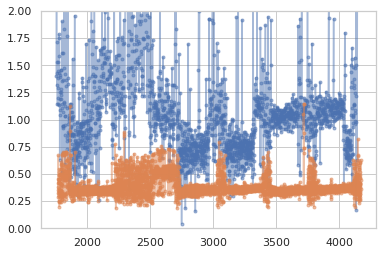

In [11]:
plt.plot(arr_breath[1:], np.diff(arr_breath), alpha=0.5, marker=".")
plt.plot(arr_step[1:], np.diff(arr_step), alpha=0.5, marker=".")
plt.ylim(0, 2)
plt.show()

(0.0, 2.0)

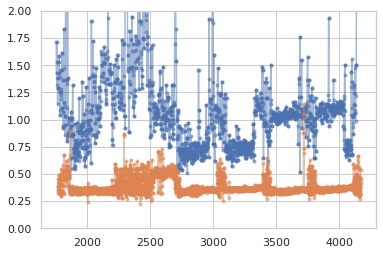

In [12]:
plt.plot(arr_breath[1:], moving_aggregation_nb(np.diff(arr_breath), w=3, aggregation="median"), alpha=0.5, marker=".")
plt.plot(arr_step[1:], moving_aggregation_nb(np.diff(arr_step), w=3, aggregation="median"), alpha=0.5, marker=".")
# plt.xlim(3700, 4100)
plt.ylim(0, 2)

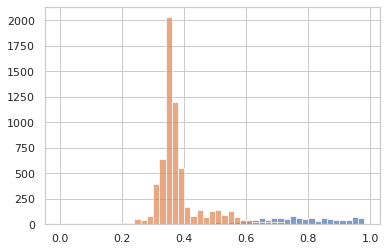

In [13]:
bins=np.arange(0,1,0.02)
plt.hist(np.diff(arr_breath), bins=bins, alpha=0.7);
plt.hist(np.diff(arr_step), bins=bins, alpha=0.7);
# plt.xlim(0, 2)

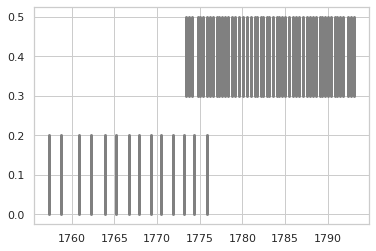

In [14]:
max_t = 20
arr1 = arr_breath[arr_breath < (arr_breath.min()+max_t)]
arr2 = arr_step[arr_step < (arr_step.min()+max_t)]

for idx, event in enumerate(arr1):
    plt.plot([event]*10, np.linspace(0, 0.2, 10), color="gray", lw=3)

for idx, event in enumerate(arr2):
    plt.plot([event]*10, np.linspace(0.3, 0.5, 10), color="grey", lw=3)


## Time delay estimation of pairs

Apply multiple $d_{\max}$ as their overlays provide the best result or simply the default value.

In [15]:
# dist_max_l = [0.005, 0.01, 0.02, 0.05, 0.1, 0.2]

# time_shifts = nearest_advocate(
#     arr_ref=arr_breath, arr_sig=arr_step,
#     td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, dist_max=dist_max_l[0],
#     symmetric=True)
# for dist_max in dist_max_l[1:]:
#     time_shifts_part = nearest_advocate(
#         arr_ref=arr_breath, arr_sig=arr_step,
#         td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, dist_max=dist_max,
#         symmetric=True)
#     time_shifts[:,1] += time_shifts_part[:,1]

# time_shifts[:,1] /= len(dist_max_l)

# # Find the argmin
# time_shift, min_mean_dist = time_shifts[np.argmin(time_shifts[:,1])]
# print(f"Found an optimum at {time_shift:.4f}s with a minimal mean distance of {min_mean_dist:.6f}s")
# #> Found an optimum at 3.15s with a minimal mean distance of 0.079508s

# # Plot result
# plt.plot(time_shifts[:,0], time_shifts[:,1], color="steelblue", label="Mean distance")
# plt.vlines(x=time_shift, ymin=min_mean_dist, ymax=np.mean(time_shifts[:,1]), color="firebrick", label=f"Shift = {time_shift:.2f}s")
# plt.xlim(time_shift-6, time_shift+6)
# # plt.xlim(TD_MIN, TD_MAX)
# plt.title("Time Delay between Breath and Steps")
# plt.xlabel("Time delay (s)")
# plt.ylabel("Mean distance (s)")
# plt.legend(loc="upper right")
# plt.show()

In [16]:
# Run with the default value
time_shifts = nearest_advocate(
    arr_ref=arr_breath, arr_sig=arr_step,
    td_min=TD_MIN, td_max=TD_MAX, sps=SAMPLES_PER_S, dist_max=None,
    symmetric=True)
time_shift, min_mean_dist = time_shifts[np.argmin(time_shifts[:,1])]
print(f"Found an optimum at {time_shift:.4f}s with a minimal mean distance of {min_mean_dist:.6f}s")

df_nearest = pd.DataFrame(time_shifts, columns=["time-delta", "distance"])

Found an optimum at -16.3000s with a minimal mean distance of 0.072705s


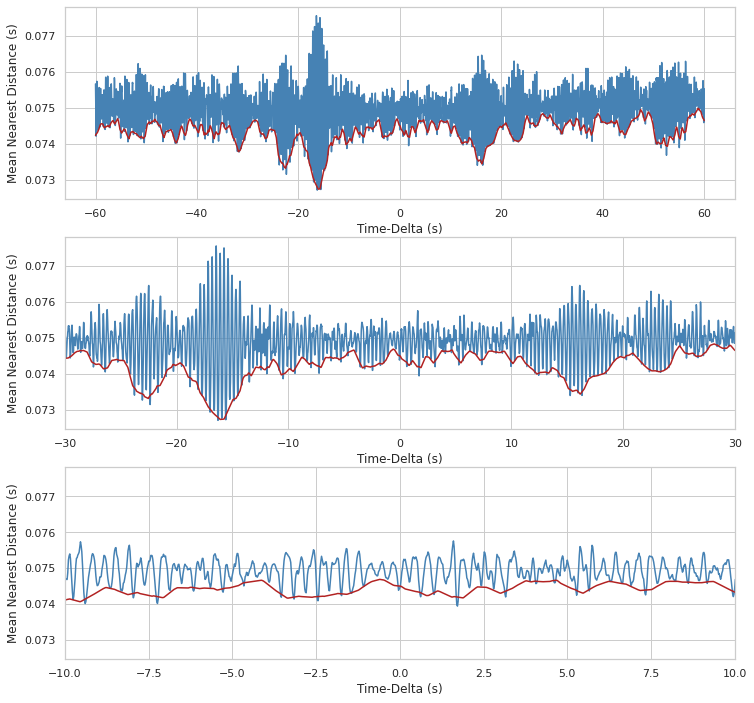

In [17]:
fig, axes = plt.subplots(3,1, figsize=(12, 12))

n_kernels = int(SAMPLE_RATE_DT * np.median(np.diff(arr_breath)))
for ax in axes:
    sns.lineplot(data=df_nearest, x="time-delta", y="distance", color="steelblue", ax=ax)
    sns.lineplot(x=df_nearest["time-delta"],
                 y=moving_aggregation(moving_aggregation(df_nearest["distance"].values, w=n_kernels, aggregation="min"), w=2*n_kernels, aggregation="mean"),
                 color="firebrick", ax=ax)
    ax.set_xlabel("Time-Delta (s)")
    ax.set_ylabel("Mean Nearest Distance (s)")

axes[1].set_xlim(-30, 30)
axes[2].set_xlim(-10, 10)
plt.show()

### Frequency analysis of the result

Seems to be not important.

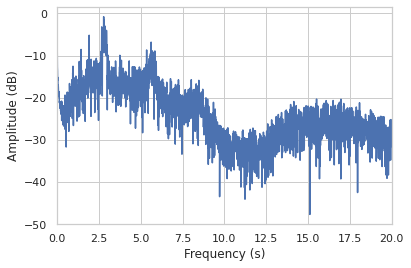

In [18]:
from scipy.fft import rfft, rfftfreq

ref_median_diff = np.median(np.diff(arr_breath))
df_nearest = pd.DataFrame(time_shifts, columns=["time-delta", "distance"])

df = df_nearest[df_nearest["distance"] < ref_median_diff / 2]
yf = rfft(np.array(df["distance"] - df["distance"].mean()))
xf = rfftfreq(len(df), 1 / SAMPLES_PER_S)

plt.plot(xf, 10*np.log10(np.abs(yf)))
plt.xlabel("Frequency (s)")
plt.ylabel("Amplitude (dB)")
plt.xlim(0, 20)
plt.show()

### Windowed NAd

In [19]:
@numba.njit
def numba_diff(x):
    return x[1:] - x[:-1]

@numba.jit(nopython=True)
def interp_nb(x_vals, x, y):
    return np.interp(x_vals, x, y)

def nearest_advocate_windowed(
        arr_r, arr_j, td_min=TD_MIN, td_max=TD_MAX, td_sps=SAMPLES_PER_S, sparse_factor=1, dist_max=0.25,
        frame_length=500, sliding_length=250, quantile_filter=0.25, bandwidth_filter=None, verbose=5):
    """Nearest Advocate over sliding windows.

    Apply the nearest advocate algorithm in sliding windows to capture
    deviations of time delays caused by a variable sample rates or clock-drift.

    Parameters
    ----------
    arr_r : np.ndarray
        R-peaks as 1D array assumed to be correct (ground truth).
    arr_j : np.ndarray
        J-peaks as 1D array from the BCG, assumed to be shifted by a variable time-delta
    sps_rel : float, optional
        Initial relative sample rate deviation factor, by default 1.0.
    td_min : float, optional
        Lower bound of the search space for the time-shift, by default -60 s.
    td_max : float, optional
        Upper bound of the search space for the time-shift, by default 60 s.
    td_sps : int, optional
        Number of investigated time-shifts per second. Default None: sets it at 10 divided by the median gap of
        each array.
    sparse_factor : int, optional
        Factor for the sparseness of signal array for the calculation, higher is faster at the cost of precision,
        by default 1.
    dist_max : float, optional
        Maximal accepted distances between two advocate events. Default 0.25 s
    frame_length : int, optional
        Length of the sliding window, by default 500 events.
    sliding_length : int, optional
        Sliding length for the window, by default 250 events.
    quantile_filter : int, optional
        Filter based on the Nearest Advocate algorithm for outlier removal, by default 0.25 to remove the 25%
        strongest outlier.
    bandwidth_filter : int, optional
        Bandwidth for the kernel density estimation for outlier removal, by default None for no KDE-based filtering.
    verbose : int, optional
        Verbosity level, by default 5.

    Returns
    -------
    df_results
        A pandas DataFrame with the nearest advocate algorithm's result for each window.
    """
    # define the window centers (with indices)
    window_centers = range(int(frame_length), int(len(arr_j)-frame_length/2), sliding_length)
    n_windows = len(window_centers)

    # results DataFrame
    df_results = pd.DataFrame({"index": np.zeros(n_windows, dtype=np.int32),
                               "timestamp": np.zeros(n_windows, dtype=np.float32),
                               "time_delta": np.zeros(n_windows, dtype=np.float32),
                               "td_hat_distance": np.zeros(n_windows, dtype=np.float32),
                               "background_min_distance": np.zeros(n_windows, dtype=np.float32),
                               "diff_distance": np.zeros(n_windows, dtype=np.float32)})
    min_distance = 1e9
    max_delta = 0.0
    n_kernels = int(2 * SAMPLE_RATE_DT * np.median(numba_diff(arr_r)) + 1)
    matrix_interp_xvals = np.arange(td_min, td_max, SPECTROSCOPY_XVAL_DT).astype(np.float32)
    matrix = np.nan * np.zeros((n_windows, len(matrix_interp_xvals)), dtype=np.float32)

    for idx, slice_idx_center in enumerate(window_centers):
        # set the indices for the current slice
        slice_idx = np.arange(
            int(slice_idx_center - frame_length / 2),
            int(slice_idx_center + frame_length / 2))

        # slice the R-peak array such that J-peak is in the intervall for all possible time-deltas
        arr_r_slice = arr_r[np.logical_and(
            arr_r > arr_j[slice_idx[0]]+td_min-1,
            arr_r < arr_j[slice_idx[-1]]+td_max+1
            )]
        # skip if the array slice has less than two events
        if len(arr_r_slice) < 2:
            continue

        # Broad search using nearest advocate
        time_shifts = nearest_advocate(
            arr_ref=arr_r_slice, arr_sig=arr_j[slice_idx],
            td_min=td_min, td_max=td_max, sps=td_sps,
            dist_max=dist_max, sparse_factor=sparse_factor)
        df_res_broad = pd.DataFrame(time_shifts, columns=["time-delta", "distance"])
        # get curvature statistics
        td_hat, td_hat_distance = time_shifts[np.argmin(time_shifts[:, 1])]  # get the optimum
        background_min_distance = df_res_broad.loc[
            np.abs(df_res_broad["time-delta"]-td_hat) > 30, "distance"
            ].min()

        # check cumulative stats
        postfix1, postfix2 = "", ""
        if background_min_distance - td_hat_distance > max_delta:
            max_delta = background_min_distance - td_hat_distance
            postfix1 = "*"
        if td_hat_distance < min_distance:
            min_distance = td_hat_distance
            postfix2 = "+"

        matrix[idx, :] = interp_nb(matrix_interp_xvals, time_shifts[:,0],
                                        moving_aggregation_nb(
                                            moving_aggregation_nb(time_shifts[:,1], w=n_kernels, aggregation="min"),
                                            w=2*n_kernels, aggregation="mean"))

        # fill the results
        df_results.loc[idx, "index"] = slice_idx_center
        df_results.loc[idx, "timestamp"] = arr_j[slice_idx_center]
        df_results.loc[idx, "time_delta"] = td_hat
        df_results.loc[idx, "td_hat_distance"] = td_hat_distance
        df_results.loc[idx, "background_min_distance"] = background_min_distance
        df_results.loc[idx, "diff_distance"] = background_min_distance - td_hat_distance
        if verbose >= 3:
            print(f"Window around: {str(slice_idx_center).rjust(5)}: ",
                  f"({df_results.loc[idx, 'timestamp']:>8.2f}s), \t", end="")
            print(f"Minimum at {td_hat:>8.3f} s, score: {td_hat_distance:.6f} ", end="")
            print(f"   others: {background_min_distance:.6f}, diff: {background_min_distance-td_hat_distance:.6f}"
                  + postfix1 + postfix2)

    # filter out default value td_min
    df_results = df_results[df_results["time_delta"] > td_min + 1e-9]

    if quantile_filter and quantile_filter > 0.0:
        # filter on internal criterion measure
        df_results = df_results[
            df_results["diff_distance"] >= df_results["diff_distance"].quantile(quantile_filter)
            ]

    # filter on KDE cluster criterion
    if bandwidth_filter:
        kde = KernelDensity(
            kernel='cosine', bandwidth=bandwidth_filter
            ).fit(df_results[["time_delta"]].values)
        time_deltas = np.linspace(td_min, td_max, td_max-td_min+1).reshape(-1, 1)
        kde_opt = time_deltas[np.argmax(kde.score_samples(time_deltas))][0]
        df_results = df_results.loc[
            (kde_opt-bandwidth_filter < df_results["time_delta"])
            & (df_results["time_delta"] < kde_opt+bandwidth_filter)]

    return df_results, matrix

In [20]:
df_results, matrix = nearest_advocate_windowed(
    arr_r=arr_breath, arr_j=arr_step, td_min=TD_MIN, td_max=TD_MAX, td_sps=SAMPLES_PER_S, dist_max=None,
    frame_length=250, sliding_length=5, quantile_filter=0.2, bandwidth_filter=40, verbose=1)
df_results.head()

index    timestamp  time_delta  td_hat_distance  background_min_distance  diff_distance
11    305  1902.681519       -1.70         0.073739                 0.074470       0.000731
13    315  1906.086914        3.84         0.073558                 0.074302       0.000744
15    325  1909.820068       13.82         0.073153                 0.073913       0.000760
18    340  1915.014526       13.82         0.073057                 0.073949       0.000892
19    345  1916.733032       15.20         0.073305                 0.074090       0.000785

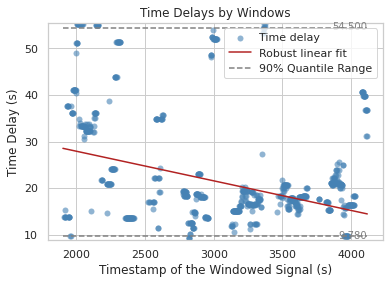

In [21]:
# Estimate a robust linear regression
# regressor = TheilSenRegressor(random_state=1)
regressor = HuberRegressor()  # Huber or Theil-Sen
quantile_range = 0.9
regressor.fit(X=df_results[["timestamp"]].values, y=df_results["time_delta"].values)
x_linspace = np.linspace(df_results["timestamp"].values[0], df_results["timestamp"].values[-1],
                            int(len(df_results)/3))
pred_y = regressor.predict(x_linspace.reshape(-1, 1))

# Add statistic
ci_low, ci_high = np.quantile(df_results["time_delta"].values,
                                ((1-quantile_range)/2, 1-(1-quantile_range)/2))

# Plot the resulting regression and estimations
plot_windowed_result(df_results, pred_y=pred_y, quantile_range=quantile_range,
                        save_fig=False, verbose=5)

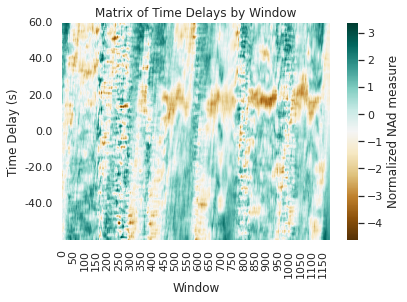

In [22]:
matrix_df = pd.DataFrame(matrix.T, index=np.arange(TD_MIN, TD_MAX, (TD_MAX-TD_MIN)/matrix.shape[1])).iloc[::-1]
matrix_df_normed = matrix_df.apply(lambda x: (x-matrix_df.mean(axis=0))/matrix_df.std(axis=0), axis=1)

ax = sns.heatmap(matrix_df_normed, linewidth=0.0, cmap="BrBG", cbar_kws={'label': 'Normalized NAd measure'})
ax.set_xlabel("Window")
ax.set_ylabel("Time Delay (s)")
ax.set_title("Matrix of Time Delays by Window")
n_yticks = 10; ax.set_yticks(np.arange(0, len(matrix_df), 20*n_yticks), labels=[f"{i:.1f}" for i in np.arange(TD_MAX, TD_MIN, -20)])

plt.show()

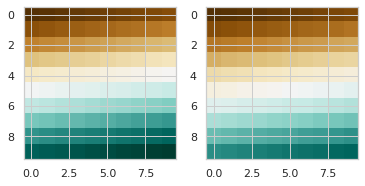

In [23]:
import matplotlib.colors as colors

################### Function to truncate color map ###################
def truncate_colormap(cmapIn='jet', minval=0.0, maxval=1.0, n=100):
    '''truncate_colormap(cmapIn='jet', minval=0.0, maxval=1.0, n=100)'''
    cmapIn = plt.get_cmap(cmapIn)

    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmapIn.name, a=minval, b=maxval),
        cmapIn(np.linspace(minval, maxval, n)))

    arr = np.linspace(0, 50, 100).reshape((10, 10))
    fig, ax = plt.subplots(ncols=2)
    ax[0].imshow(arr, interpolation='nearest', cmap=cmapIn)
    ax[1].imshow(arr, interpolation='nearest', cmap=new_cmap)
    plt.show()

    return new_cmap

palette = truncate_colormap(cmapIn=sns.color_palette("BrBG", as_cmap=True), minval=0.0, maxval=.9)

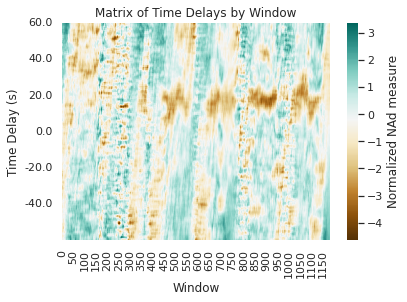

In [24]:
matrix_df = pd.DataFrame(matrix.T, index=np.arange(TD_MIN, TD_MAX, (TD_MAX-TD_MIN)/matrix.shape[1])).iloc[::-1]
matrix_df_normed = matrix_df.apply(lambda x: (x-matrix_df.mean(axis=0))/matrix_df.std(axis=0), axis=1)

ax = sns.heatmap(
    matrix_df_normed, linewidth=0.0, cbar_kws={'label': 'Normalized NAd measure'}, cmap=palette)
ax.set_xlabel("Window")
ax.set_ylabel("Time Delay (s)")
ax.set_title("Matrix of Time Delays by Window")
n_yticks = 10; ax.set_yticks(np.arange(0, len(matrix_df), 20*n_yticks), labels=[f"{i:.1f}" for i in np.arange(TD_MAX, TD_MIN, -20)])

# ax.collections[0].set_clim(-4, 2)
plt.show()

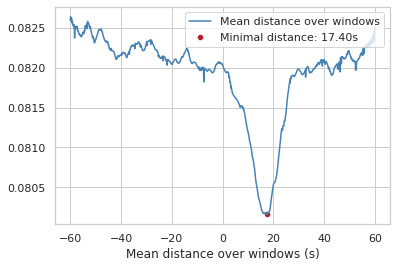

In [25]:
matrix_mean_df = matrix_df[matrix_df < matrix_df.max()].mean(axis=1)

sns.lineplot(data=matrix_mean_df, color="steelblue", label="Mean distance over windows")
sns.scatterplot(x=[matrix_mean_df.index[matrix_mean_df.argmin()]], y=[matrix_mean_df.iloc[matrix_mean_df.argmin()]],
                color="firebrick", label=f"Minimal distance: {matrix_mean_df.index[matrix_mean_df.argmin()]:.2f}s")
plt.xlabel("Time-Delta (s)")
plt.xlabel("Mean distance over windows (s)")
plt.legend(loc="upper right")
plt.show()

In [26]:
def plot_mean_matrix(df_results, matrix, savefig=None):
    # Create a figure with subplots
    fig = plt.figure(figsize=(10, 8.5))  # Total figure size

    # Upper left plot (6x4)
    ax1 = plt.subplot2grid((3, 3), (0, 0), rowspan=1, colspan=2, fig=fig)
    # Bottom left plot (6x6)
    ax2 = plt.subplot2grid((3, 3), (1, 0), rowspan=2, colspan=2, fig=fig)
    # Bottom right plot (4x6)
    ax3 = plt.subplot2grid((3, 3), (1, 2), rowspan=2, colspan=1, fig=fig)

    # Plotting the first plot (robust linear regression)
    # regressor = TheilSenRegressor(random_state=1)
    regressor = HuberRegressor()  # Huber or Theil-Sen
    quantile_range = 0.9
    regressor.fit(X=df_results[["timestamp"]].values, y=df_results["time_delta"].values)
    x_linspace = np.linspace(df_results["timestamp"].values[0], df_results["timestamp"].values[-1],
                                int(len(df_results)/3))
    pred_y = regressor.predict(x_linspace.reshape(-1, 1))
    sns.scatterplot(data=df_results, x="timestamp", y="time_delta", color="steelblue",
                label="Time delay", alpha=0.6, linewidth=0.0, ax=ax1)
    sns.lineplot(x=x_linspace, y=pred_y, color="firebrick", label="Robust linear fit", ax=ax1)
    ci_low, ci_high = np.quantile(df_results["time_delta"].values,
                                    ((1-quantile_range)/2, 1-(1-quantile_range)/2))
    sns.lineplot(x=x_linspace, y=ci_low, color="gray", linestyle='--',
                    label=f"{int(100*quantile_range)}% Quantile Range", ax=ax1)
    sns.lineplot(x=x_linspace, y=ci_high, color="gray", linestyle='--', ax=ax1)
    ax1.text(max(x_linspace), ci_low - 0.1, f"{ci_low:.3f}", ha="right", va="center", color="gray")
    ax1.text(max(x_linspace), ci_high + 0.08, f"{ci_high:.3f}", ha="right", va="center", color="gray")
    ax1.set_xlabel("Timestamp of the Windowed Signal (s)")
    ax1.set_ylabel("Time Delay (s)")
    ax1.set_title("Time Delay by Window")
    ylim = tuple(df_results["time_delta"].quantile([0.05, 0.95]).values + [-1.0, 1.0])
    ax1.set_ylim(ylim)
    ax1.legend(loc="lower left")

    # Matrix Plot
    matrix_df = pd.DataFrame(matrix.T, index=np.arange(TD_MIN, TD_MAX, (TD_MAX-TD_MIN)/matrix.shape[1])).iloc[::-1]
    matrix_df_normed = matrix_df.apply(lambda x: (x-matrix_df.mean(axis=0))/matrix_df.std(axis=0), axis=1)
    sns.heatmap(matrix_df_normed, linewidth=0.0, cmap=palette, cbar_kws={'label': 'Normalized NAd measure'}, ax=ax2)
    ax2.set_xlabel("Window")
    ax2.set_ylabel("Time Delay (s)")
    ax2.set_title("Matrix of Time Delays by Window")
    n_yticks = 10; ax2.set_yticks(np.arange(0, len(matrix_df), 20*n_yticks), labels=[f"{i:.1f}" for i in np.arange(TD_MAX, TD_MIN, -20)])

    # Aggregate Time-delays over windows
    matrix_mean_df = matrix_df[matrix_df < matrix_df.max()].mean(axis=1)
    ax3.plot(matrix_mean_df.values, matrix_mean_df.index, color="steelblue", label="Mean distance")
    ax3.scatter([matrix_mean_df.iloc[matrix_mean_df.argmin()]], [matrix_mean_df.index[matrix_mean_df.argmin()]],
                color="firebrick", label=f"Time delay = {matrix_mean_df.index[matrix_mean_df.argmin()]:.2f}s")
    ax3.set_xlabel("Mean distance (s)")
    ax3.set_ylabel("Mean Time Delay over Windows (s)")
    ax3.set_title("Mean Time Delay")
    ax3.legend(loc="lower right")

    plt.tight_layout()
    if savefig:
        plt.savefig(savefig, dpi=250)
    plt.show()


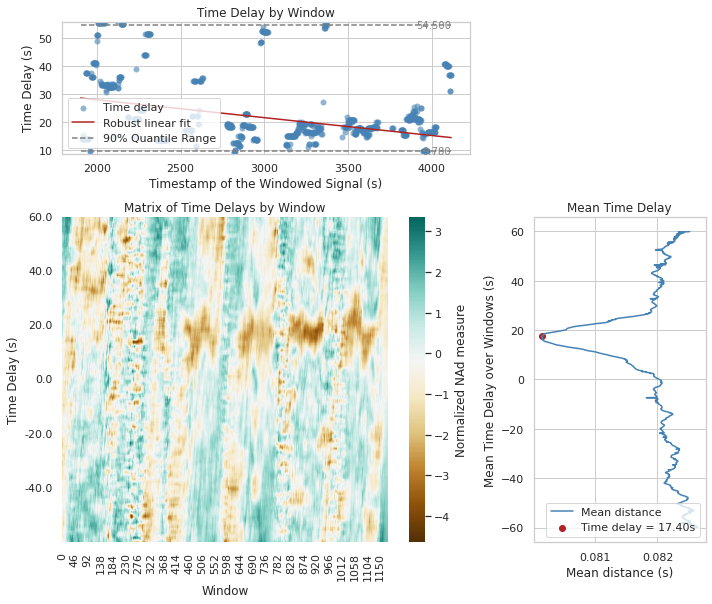

In [27]:
# plot the result
plot_mean_matrix(df_results, matrix, savefig=f"fig/{pid}_{typ}_plot.png")

## Run of all pairs of measurements


########################################################
Time-Delay Estimation of pid P06 and reference arrays.


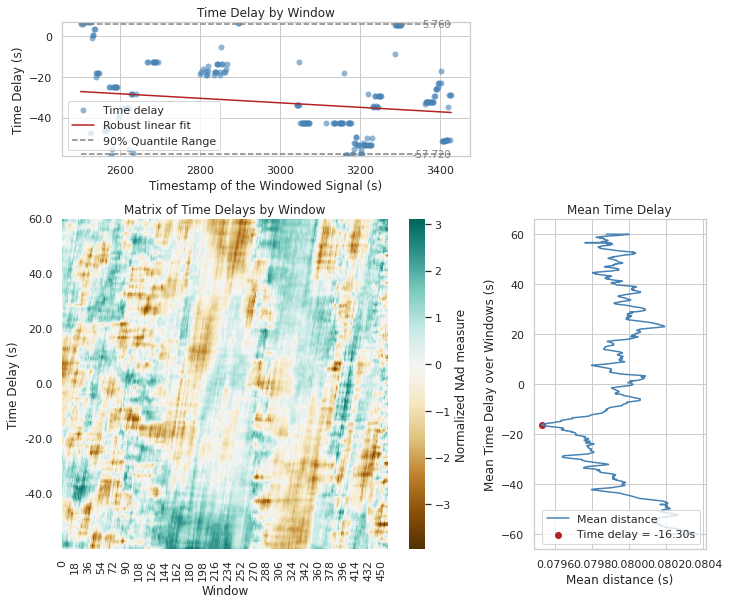


########################################################
Time-Delay Estimation of pid P06 and signal arrays.


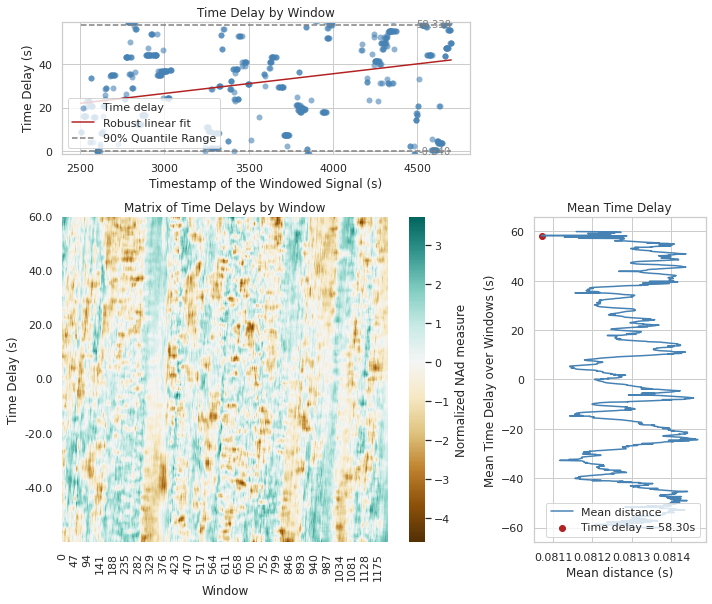


########################################################
Time-Delay Estimation of pid P07 and reference arrays.


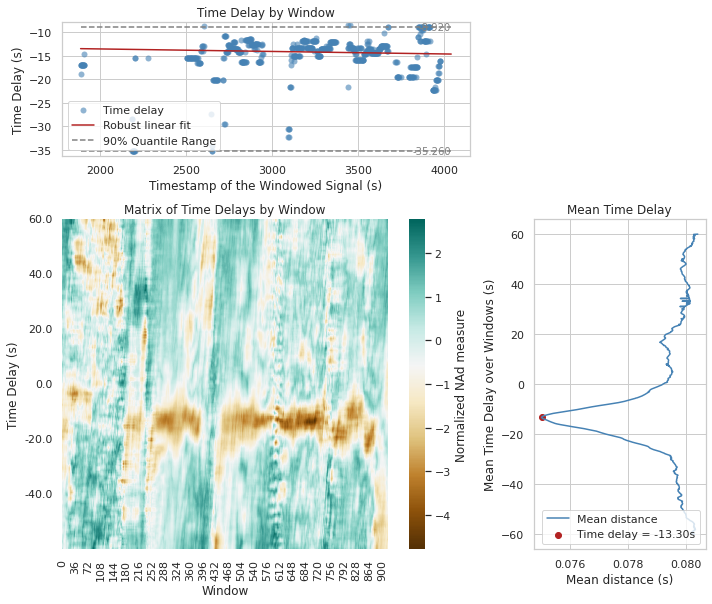


########################################################
Time-Delay Estimation of pid P07 and signal arrays.


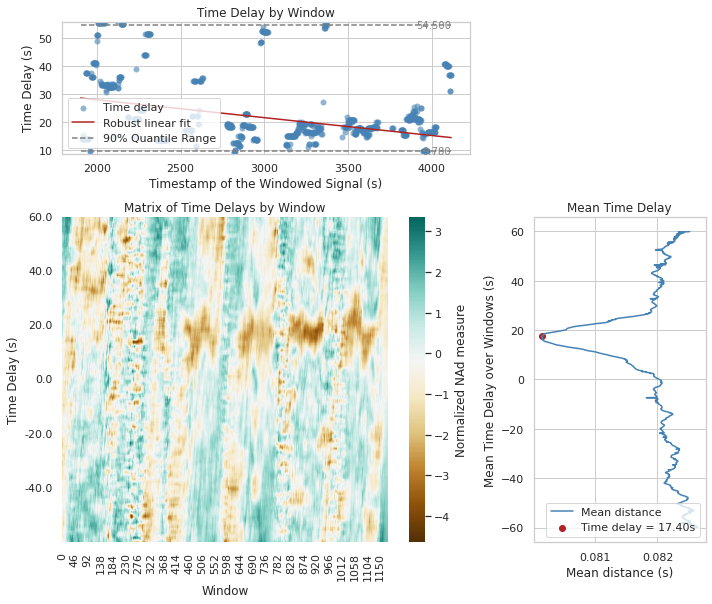


########################################################
Time-Delay Estimation of pid P08 and reference arrays.


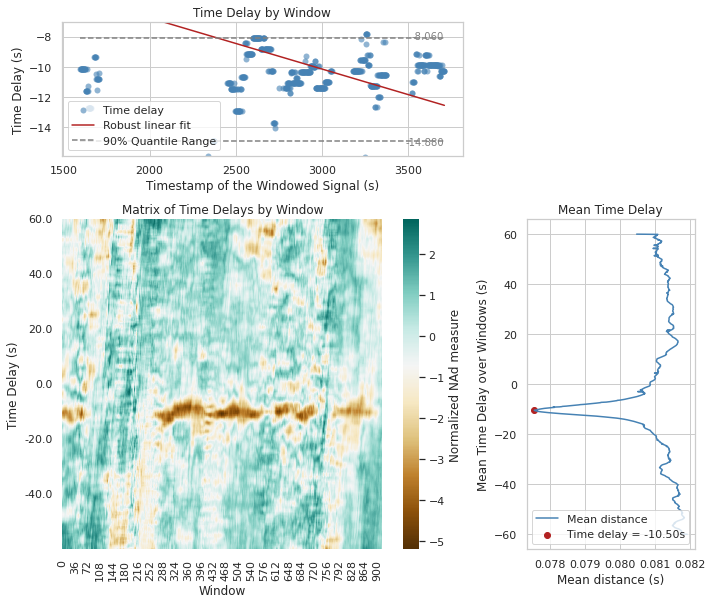


########################################################
Time-Delay Estimation of pid P08 and signal arrays.


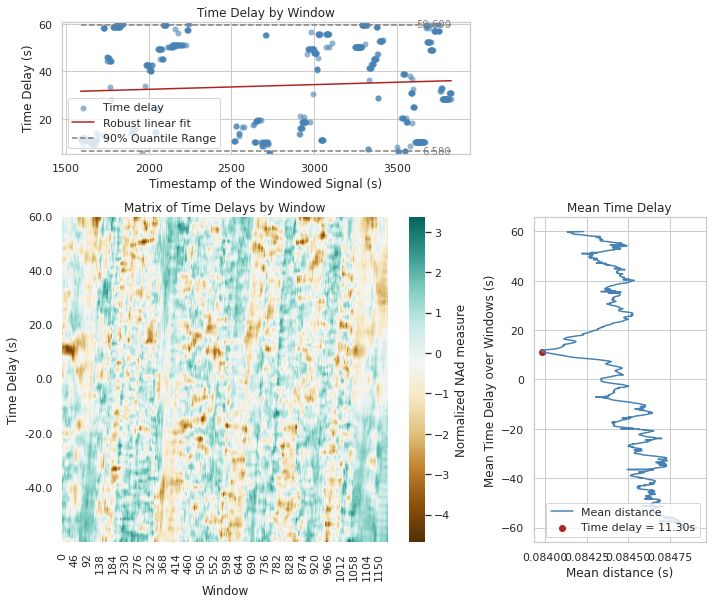


########################################################
Time-Delay Estimation of pid P09 and reference arrays.


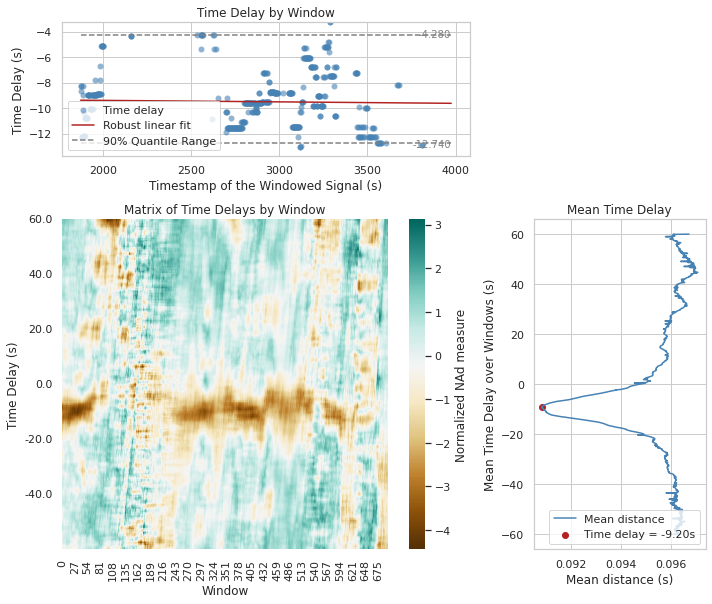


########################################################
Time-Delay Estimation of pid P09 and signal arrays.


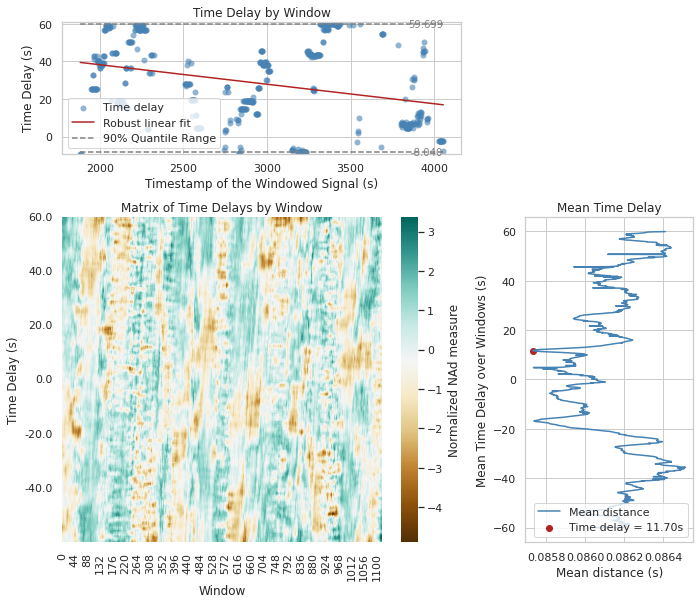


########################################################
Time-Delay Estimation of pid P10 and reference arrays.


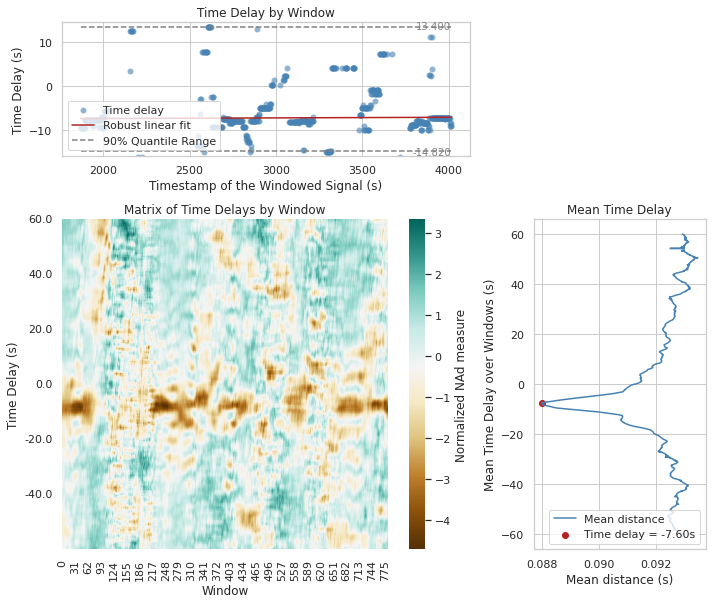


########################################################
Time-Delay Estimation of pid P10 and signal arrays.


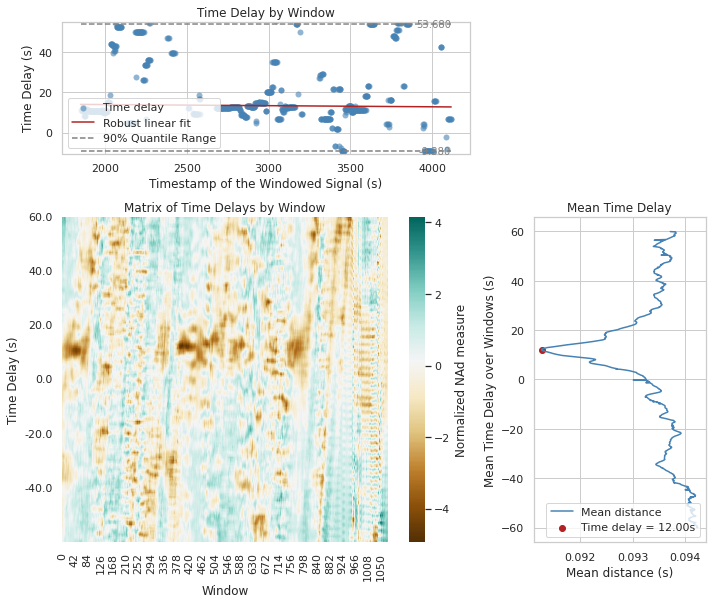


########################################################
Time-Delay Estimation of pid P11 and reference arrays.


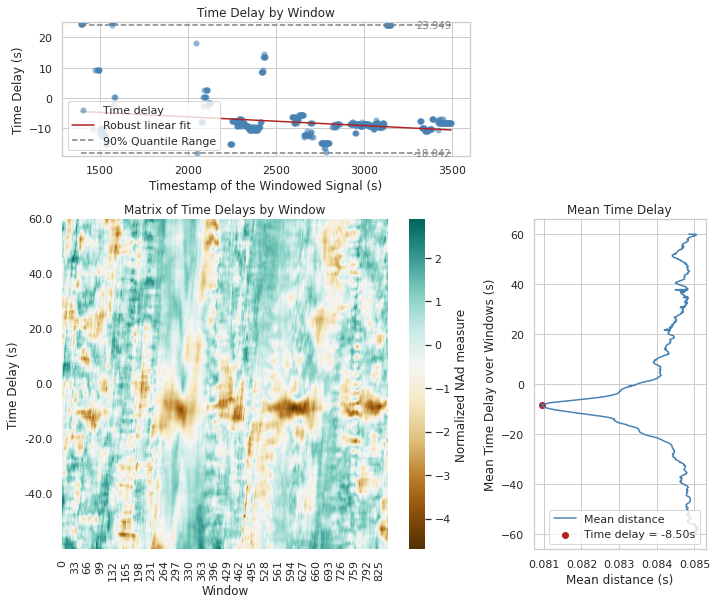


########################################################
Time-Delay Estimation of pid P11 and signal arrays.


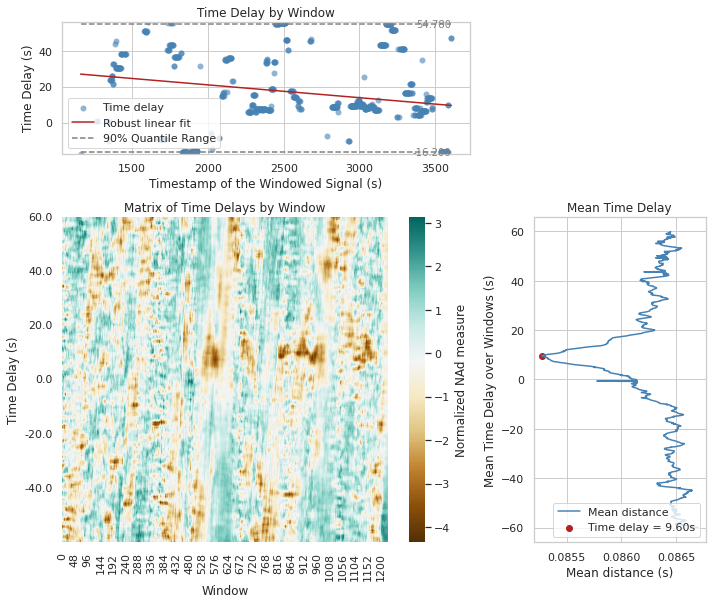


########################################################
Time-Delay Estimation of pid P12 and reference arrays.


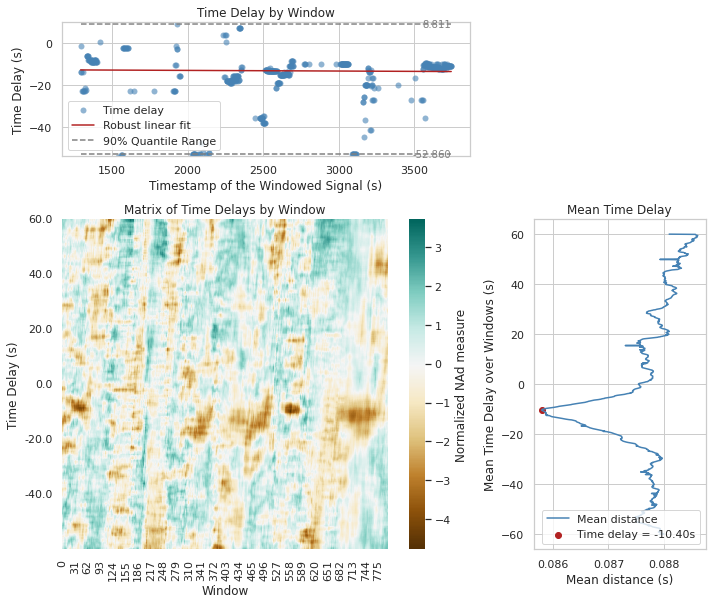


########################################################
Time-Delay Estimation of pid P12 and signal arrays.


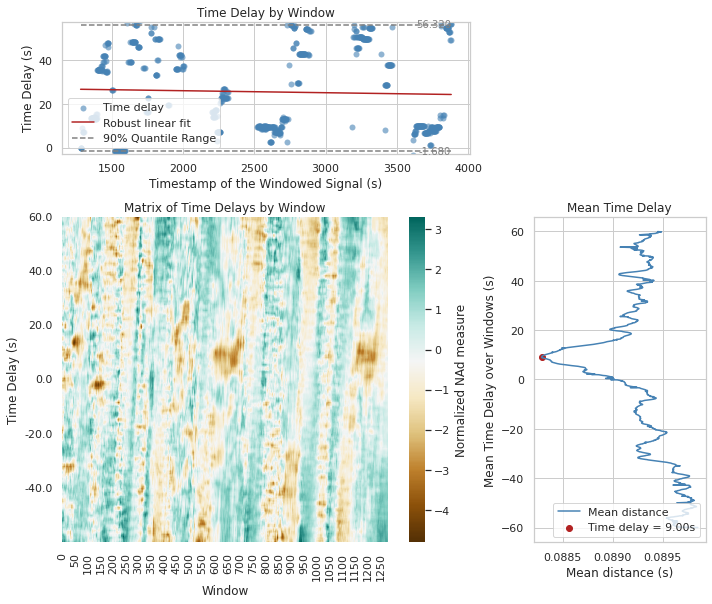


########################################################
Time-Delay Estimation of pid P13 and reference arrays.


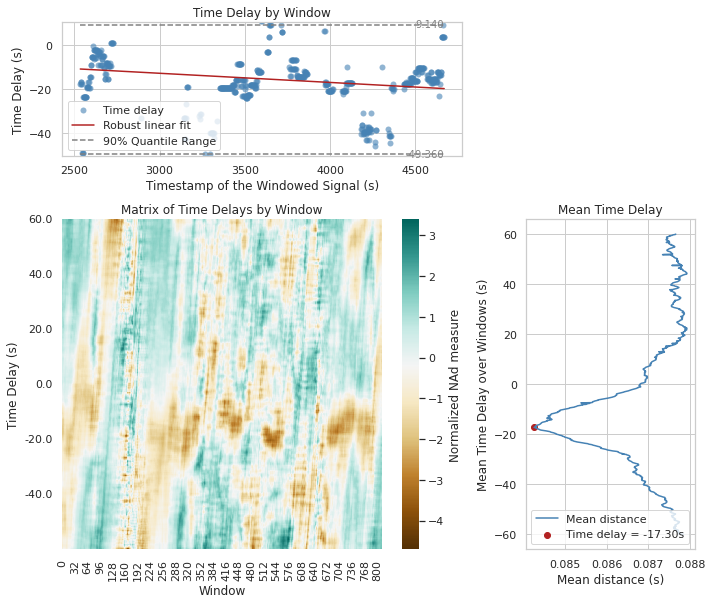


########################################################
Time-Delay Estimation of pid P13 and signal arrays.


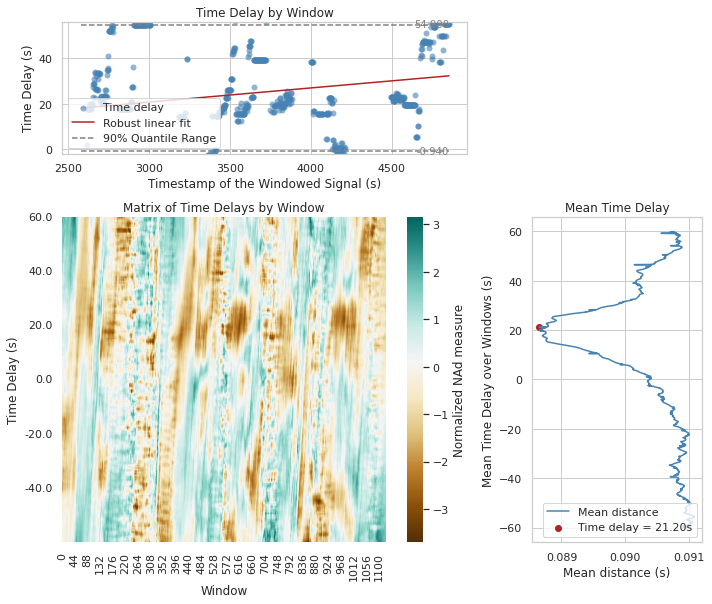


########################################################
Time-Delay Estimation of pid P16 and reference arrays.


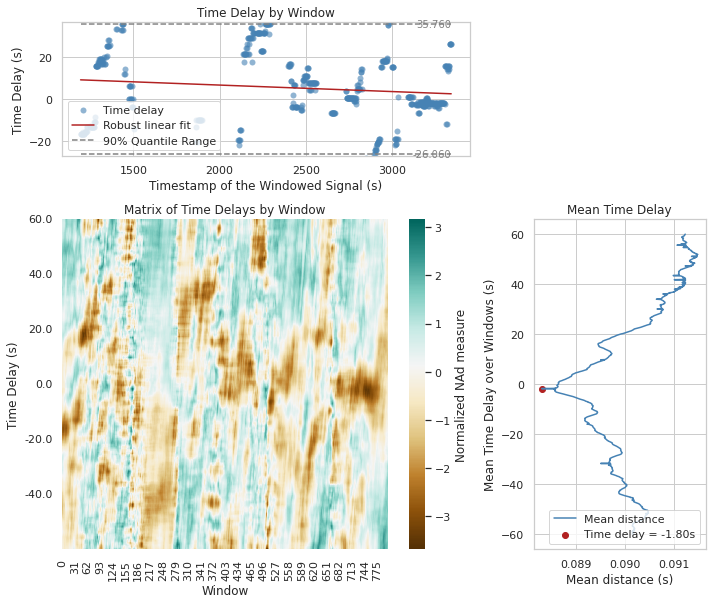


########################################################
Time-Delay Estimation of pid P16 and signal arrays.


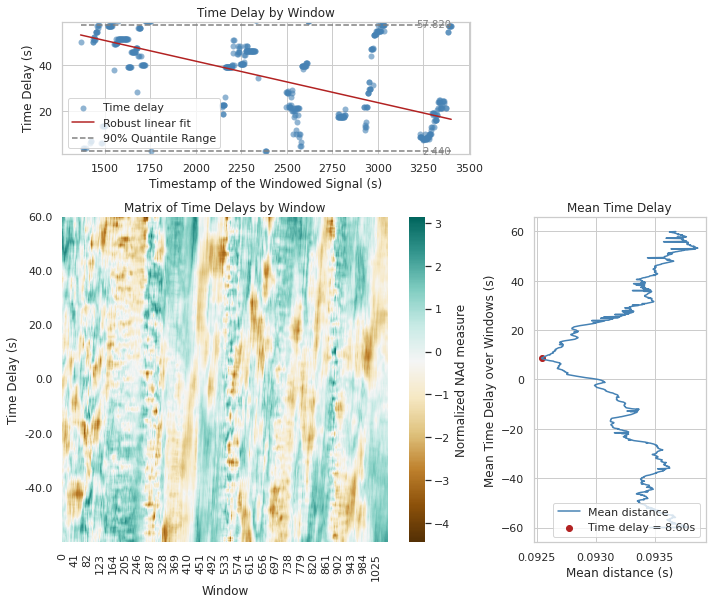


########################################################
Time-Delay Estimation of pid P19 and reference arrays.


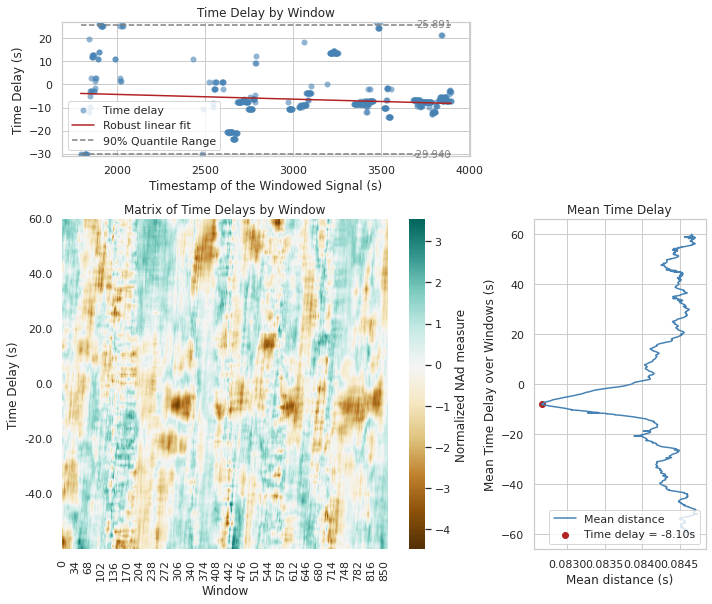


########################################################
Time-Delay Estimation of pid P19 and signal arrays.


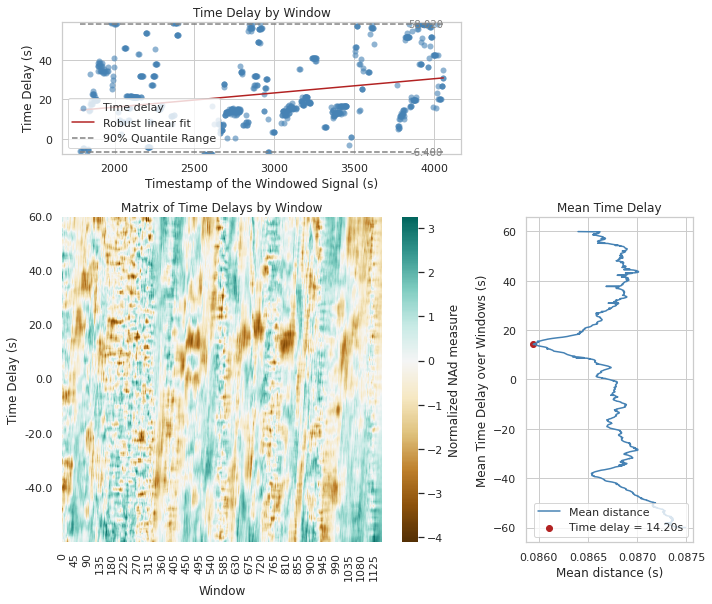


########################################################
Time-Delay Estimation of pid P21 and reference arrays.


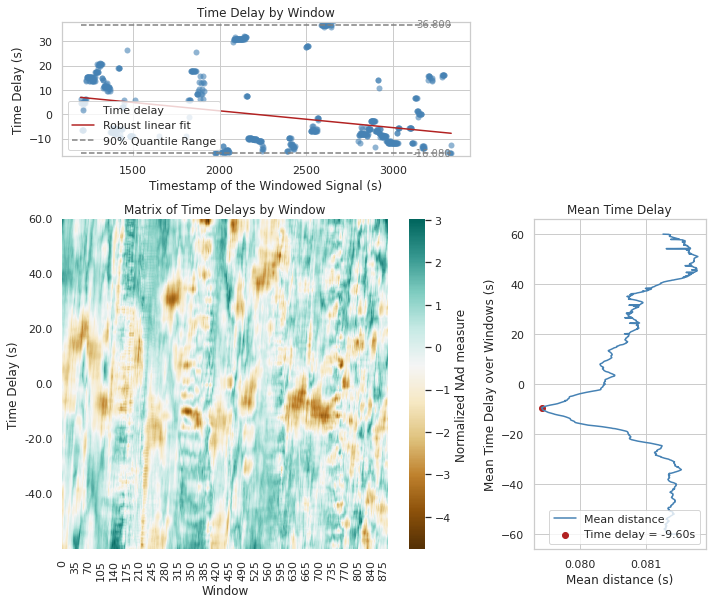


########################################################
Time-Delay Estimation of pid P21 and signal arrays.


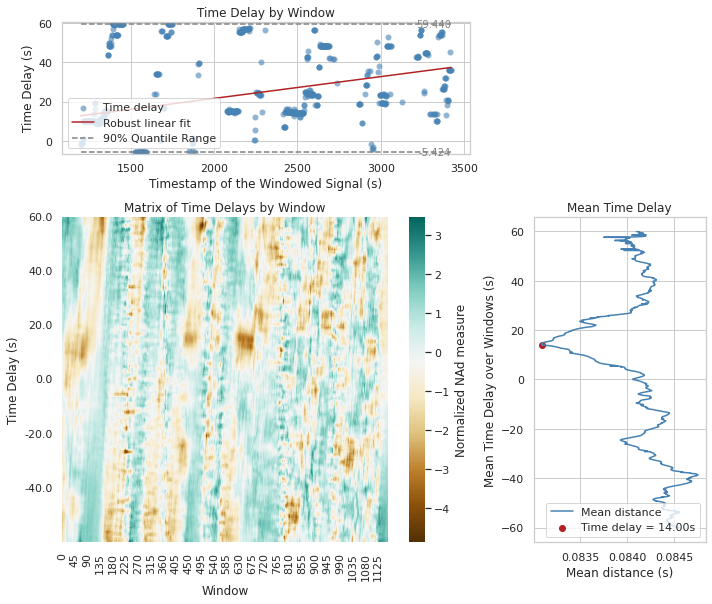


########################################################
Time-Delay Estimation of pid P23 and reference arrays.


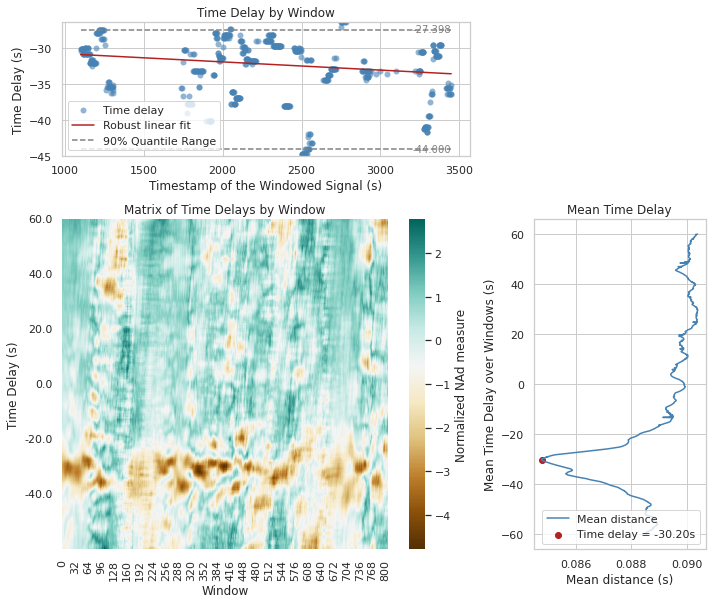


########################################################
Time-Delay Estimation of pid P23 and signal arrays.


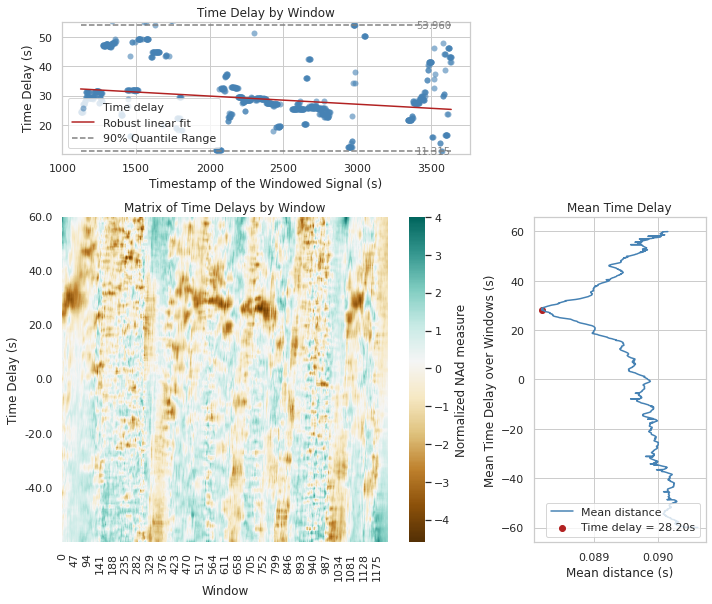

In [28]:
refs = [True, False]

for pid in step_rate_dataset_d.keys():
    for ref in refs:
        typ = 0 if ref else 1
        arr_breath = breath_rate_dataset_d.get(pid, [None, None])[typ]  # [:1000]
        arr_step = step_rate_dataset_d.get(pid, [None, None])[typ]  # [:1000]
        if arr_breath is None or arr_step is None:
            continue
        print("\n########################################################")
        print(f"Time-Delay Estimation of pid {pid} and {'reference' if ref else 'signal'} arrays.")


        df_results, matrix = nearest_advocate_windowed(
            arr_r=arr_breath, arr_j=arr_step, td_min=TD_MIN, td_max=TD_MAX, td_sps=SAMPLES_PER_S, dist_max=None,
            frame_length=250, sliding_length=5, quantile_filter=0.2, bandwidth_filter=40, verbose=1)
        # df_results.head()

        # plot the result
        plot_mean_matrix(df_results, matrix)